In [1]:
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = BRANDON
os.chdir(ROOT_DIR + 'testing-framework/')

from utilities import *
from plot_utilities import *

import matlab.engine 
eng = matlab.engine.connect_matlab()

np.random.seed(42)

In [2]:
n = 3100
r = 2
eta = 3
sample = sample_prior(r, eta, size = n)
sample

array([-0.96543757,  0.43894945,  1.26724866, ...,  0.14989722,
        0.72525281,  0.30072679])

In [3]:
print(kurtosis_prior(r, eta))
bootstrap_metric(sample, metric = stats.kurtosis, n_bootstrap=100, ci = 0.95)[1:3]

0.34965247228542395


(0.11540337206431303, 0.5467605745832642)

In [32]:
total = 100
num_pass = 0
true_stat = kurtosis_prior(r, eta)
sample = sample_prior(r, eta, size = n)
for i in range(total):
    interval = bootstrap_metric(sample, metric = stats.kurtosis, n_bootstrap=1000, ci = 0.95)[1:3]
    if interval[0] <= true_stat <= interval[1]:
        num_pass += 1

num_pass/total

1.0

In [13]:
def nearby_df_KS(r, eta, n=10000, bound=0.1, grid_amt= 5, iterations = 10, rounded = 3):
    prior_cdf = compute_prior_cdf(r, eta, n_samples= 1000, tail_percent=.1, tail_bound= 0.0001, debug = False, use_matlab=True, eng = eng)
    check_r = np.linspace(r-bound, r+bound, 2*grid_amt+1)

    check_eta = np.linspace(eta-bound, eta+bound, 2*grid_amt+1)

    df = pd.DataFrame(columns = ["r", "eta", "distance", "pvalue"])
    for r_prime in check_r:
        for eta_prime in check_eta:
            total_distance, total_pvalue = 0, 0
            r_prime = np.round(r_prime, rounded)
            eta_prime = np.round(eta_prime, rounded)
            for _ in range(iterations):
                obs_x = sample_prior(r_prime, eta_prime, size = n)
                distance, pvalue = kstest_custom(obs_x, prior_cdf)
                total_distance += distance
                total_pvalue += pvalue
            
            avg_distance = total_distance/iterations
            avg_pvalue = total_pvalue/iterations
            df.loc[len(df)] = [r_prime, eta_prime, avg_distance, avg_pvalue]
    return df

In [14]:
def KSHeatMap(r, eta, n=10000, bound=0.1, grid_amt= 5, iterations = 10, dist = True, pval = True, rounded = 3):
    df = nearby_df_KS(r, eta, iterations=iterations, n=n, bound = bound, grid_amt=grid_amt, rounded=rounded)
    if dist:
        fig, ax = plt.subplots(figsize=(1.6*grid_amt, 1.6*grid_amt))
        result = df.pivot(index='eta', columns='r', values='distance').sort_values("eta", ascending=True)
        sns.heatmap(result, annot=True, fmt=f".3f", ax =ax, square=True)
        plt.title(f"r = {r} eta = {eta}, Distances")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        ax.invert_yaxis()
        plt.show()
    if pval:
        fig, ax = plt.subplots(figsize=(1.6*grid_amt, 1.6*grid_amt))
        result = df.pivot(index='eta', columns='r', values='pvalue').sort_values("eta", ascending=True)
        sns.heatmap(result, annot=True, fmt=f".3f", cmap = "RdYlGn", vmin = 0.01, vmax = 0.2, square=True)
        plt.title(f"r = {r} eta = {eta}, pvalues")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        ax.invert_yaxis()
        plt.show()

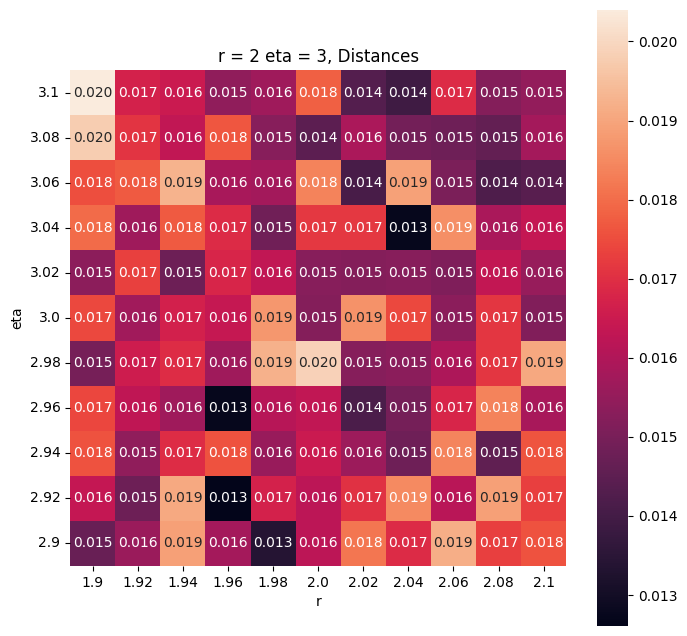

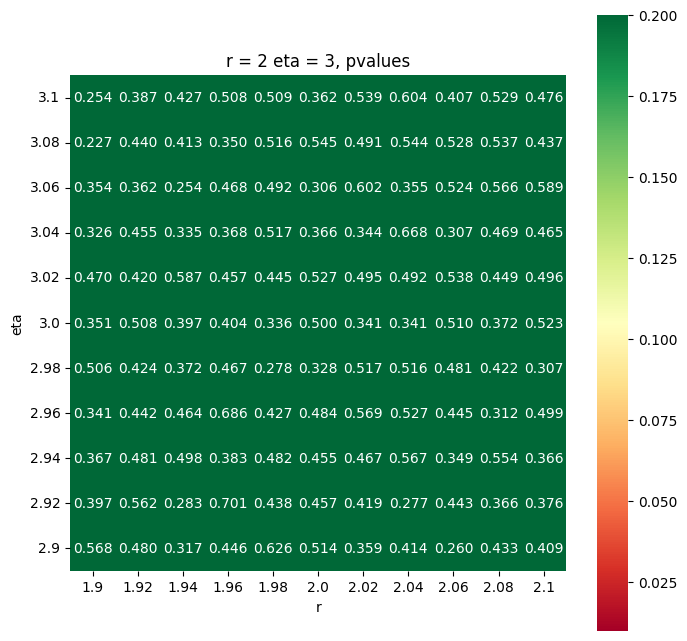

In [15]:
KSHeatMap(2,3,n)

In [27]:
def nearby_df(r, eta, metric, n=10000, bound=0.1, grid_amt= 5, iterations = 10, rounded = 3):
    check_r = np.linspace(r-bound, r+bound, 2*grid_amt+1)

    check_eta = np.linspace(eta-bound, eta+bound, 2*grid_amt+1)

    df = pd.DataFrame(columns = ["r", "eta", "distance", "passes"])
    for r_prime in check_r:
        for eta_prime in check_eta:
            total_distance, total_pvalue = 0, 0
            r_prime = np.round(r_prime, rounded)
            eta_prime = np.round(eta_prime, rounded)
            for _ in range(iterations):
                obs_x = sample_prior(r_prime, eta_prime, size = n)
                distance, pvalue = metric(obs_x)
                total_distance += distance
                total_pvalue += pvalue
            
            avg_distance = total_distance/iterations
            avg_pvalue = total_pvalue/iterations
            df.loc[len(df)] = [r_prime, eta_prime, avg_distance, avg_pvalue]
    return df

In [30]:
def HeatMap(r, eta, metric, n=10000, bound=0.1, grid_amt= 5, iterations = 10, dist = True, pval = True, rounded = 3):
    df = nearby_df(r, eta, metric, iterations=iterations, n=n, bound = bound, grid_amt=grid_amt, rounded=rounded)
    if dist:
        fig, ax = plt.subplots(figsize=(1.6*grid_amt, 1.6*grid_amt))
        result = df.pivot(index='eta', columns='r', values='distance').sort_values("eta", ascending=True)
        sns.heatmap(result, annot=True, fmt=f".3f", ax =ax, square=True)
        plt.title(f"r = {r} eta = {eta}, Distances")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        ax.invert_yaxis()
        plt.show()
    if pval:
        fig, ax = plt.subplots(figsize=(1.6*grid_amt, 1.6*grid_amt))
        result = df.pivot(index='eta', columns='r', values='passes').sort_values("eta", ascending=True)
        sns.heatmap(result, annot=True, fmt=f".3f", cmap = "RdYlGn", vmin = 0.01, vmax = 0.2, square=True)
        plt.title(f"r = {r} eta = {eta}, Pass Pct")
        plt.yticks(rotation=0)
        plt.xticks(rotation=0)
        ax.invert_yaxis()
        plt.show()

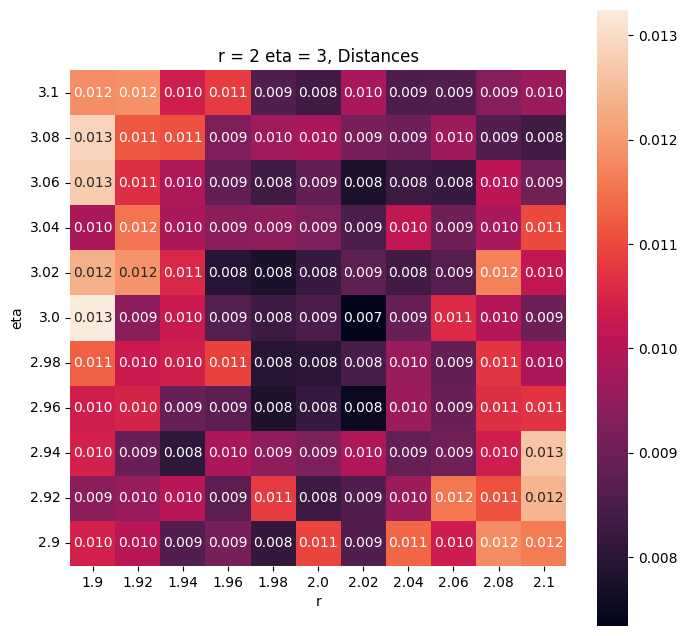

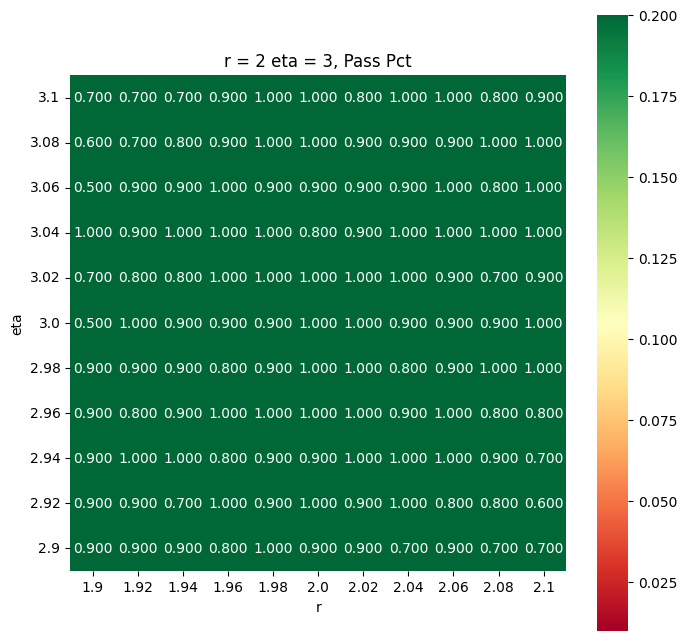

In [31]:
cdf = compute_prior_cdf(r, eta, n_samples= 1000, tail_percent=.1, tail_bound= 0.0001, debug = False, use_matlab=True, eng = eng)
def ks_metric(x, cdf = cdf):
    dist, pval = kstest_custom(x, cdf)
    if pval <0.05:
        ifpass = 0
    else:
        ifpass = 1
    return dist, ifpass
HeatMap(2,3, ks_metric)